In [1]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import scipy as sci
import matplotlib.ticker as ticker
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from IPython.display import display, Latex
from sympy import pprint
from scipy.optimize import minimize as GDlib

In [2]:
theta1, theta2, phi1, phi2, alpha = sym.symbols('theta1 theta2 phi1 phi2 alpha')
c1, c2, s1, s2, w1, w2 = sym.cos(theta1), sym.cos(theta2), sym.sin(theta1), sym.sin(theta2), sym.cos(alpha)**2, sym.sin(alpha)**2

def Creating_states( params = [0, m.pi/2,0, 0, m.pi/4], input_type = 'theta', Abstract = False):    # coeff list like [a0,a1,b0,b1]
    a0, a1 = sym.cos(theta1), sym.exp(sym.I*phi1)*sym.sin(theta1)
    b0, b1 = sym.cos(theta2), sym.exp(sym.I*phi2)*sym.sin(theta2)
    alpha = sym.symbols('alpha')        # Doesn't work without it for some reason..
    if Abstract == False:
        alpha = params[4] 
        a0, a1, b0, b1 = a0.subs({theta1 : params[0]}), a1.subs({theta1 : params[0], phi1 : params[2]}), b0.subs({theta2 : params[1]}), b1.subs({theta2 : params[1], phi2: params[3]})
        alpha = params[4] 
        coeff_raw = [a0,a1, b0, b1]
        coeff = [i if abs(i)> 1e-9 else 0 for i in coeff_raw]
        a0, a1, b0, b1 = coeff[0],coeff[1],coeff[2],coeff[3]
    psi0, psi1 = sym.Matrix([a0,a1]), sym.Matrix([b0,b1])      # defining states
    
    psi0psi0_list, psi1psi1_list = [psi0[0]*psi0[0], psi0[1]*psi0[1], (np.sqrt(2)*psi0[0]*psi0[1]) ],  [psi1[0]*psi1[0],psi1[1]*psi1[1], (np.sqrt(2)*psi1[0]*psi1[1])] # @@@ the square rooting is simplistic. see notebook for better
    # note the order is now how prof Hillery is using ie. [|00>, |11>, |+>] (instead of the previous order [|00>, |+>, |11> ])
    psi0psi0, psi1psi1 = sym.Matrix(psi0psi0_list), sym.Matrix(psi1psi1_list)
    rho = sym.cos(alpha)**2*(psi0psi0*psi0psi0.T)+ sym.sin(alpha)**2*(psi1psi1*psi1psi1.T)
    return([[psi0,psi1], [psi0psi0,psi1psi1], rho])

# # analytic formuale for the probabilities, as given in the notes
pr1 = (1/6)*(w1*s1**2*(1+c1**2 -2*m.sqrt(2)*sym.cos(phi1)*s1*c1)+w2*s2**2*(1+c2**2-2*m.sqrt(2)*sym.cos(phi2)*s2*c2))
pr2 = (1/6)*(w1*c1**2*(1+s1**2 -2*m.sqrt(2)*sym.cos(phi1)*c1*s1) + w2*c2**2*(1+s2**2*-2*m.sqrt(2)*sym.cos(phi2)*c2*s2))
pr3 = (1/6)*(w1*(c1**4+s1**4 -2*sym.cos(2*phi1)*s1**2*c1**2)+ w2*(c2**4+ s2**4 - 2*sym.cos(2*phi2)*s2**2*c2**2))
pr4 = (1/6)*(w1*s1**2*(1+c1**2 -2*m.sqrt(2)*sym.cos(phi1+2*m.pi/3)*s1*c1)+ w2*s2**2*(1+c2**2-2*m.sqrt(2)*sym.cos(phi2+2*m.pi/3)*s2*c2))
pr5= (1/6)*(w1*c1**2*(1+s1**2 -2*m.sqrt(2)*sym.cos(phi1-2*m.pi/3)*c1*s1)+ w2*c2**2*(1+s2**2-2*m.sqrt(2)*sym.cos(phi2-2*m.pi/3)*c2*s2))
pr6 = (1/6)*(w1*(c1**4+s1**4-2*sym.cos(2*phi1 - 2*m.pi/3)*c1**2*s1**2)+ w2*(c2**4+s2**4-2*sym.cos(2*phi2 - 2*m.pi/3)*c2**2*s2**2))
pr7 = (1/6)*(w1*s1**2*(1+c1**2-2*m.sqrt(2)*sym.cos(phi1-2*m.pi/3)*s1*c1)+ w2*s2**2*(1+c2**2-2*m.sqrt(2)*sym.cos(phi2-2*m.pi/3)*s2*c2))
pr8 = (1/6)*(w1*c1**2*(1+s1**2-2*m.sqrt(2)*sym.cos(phi1-2*m.pi/3)*c1*s1)+ w2*c2**2*(1+s2**2-2*m.sqrt(2)*sym.cos(phi2-2*m.pi/3)*c2*s2))
pr9 = (1/6)*(w1*(c1**4+s1**4-2*sym.cos(2*phi1+2*m.pi/3)*c1**2*s1**2)+ w2*(c2**4+s2**4-2*sym.cos(2*phi2+2*m.pi/3)*c2**2*s2**2))
pr = [pr1, pr2,pr3, pr4,pr5, pr6,pr7, pr8,pr9]      # list of analytic prob.

w = m.e**((2/3)*m.pi*(1j))     # third root of unity
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrices

def num_experiment(N = 10000, params = [0,m.pi/2,0,0,m.pi/4], show_calcs = False):
    creation = Creating_states( params = params, Abstract = 0) # theoretical rho
    states = creation[0]
    rho = creation[-1]
    # print(rho)
    # print(states)
    prob_vec_sympy =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)]    # created list of Th probabilities
    prob_vec_raw = [(float(i.as_real_imag()[0])+float(i.as_real_imag()[1])*1j) for i in prob_vec_sympy]  # this is to avoid error, to convert sympy float to ordinary number
    prob_vec = [round(i.real, 10) for i in prob_vec_raw if abs(i.imag) < .0001]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials
    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     

    if show_calcs == True: 
        print("\n rho \n", rho)
        print("\n prob vec", prob_vec)
        print("\n nj vec",nj_vec)
        print("\n sum pj, sum nj ", sum(prob_vec), sum(nj_vec))
    return [states, rho, prob_vec, nj_vec]



In [3]:
#rough
"""print(([i/sum(num_experiment()[-1]) for i in num_experiment()[-1]]) ) # Numerical probabilities
print(num_experiment()[-2] )       # th prob

print([i.subs({theta1: 0, theta2: m.pi/2, phi1:0, phi2:0, alpha: m.pi/4}) for i in pr] )   # analytical probabilities
abs_k = [np.trace(np.outer(Creating_states(Abstract=1)[-1], POVM_elts[i])) for i in range(len(POVM_elts))]
print([i.subs({theta1: 0, theta2: m.pi/2, phi1:0, phi2:0, alpha: m.pi/4}) for i in abs_k] )   # sympy analytical prob
"""
# [0.0807, 0.0806, 0.1698, 0.0828, 0.0863, 0.1653, 0.0834, 0.0806, 0.1705]
# [0.0833, 0.0833, 0.1666, 0.0833, 0.0833, 0.1666, 0.0833, 0.0833, 0.166]
# [0.0833, 0.08333, 0.166, 0.0833, 0.0833, 0.166, 0.0833, 0.0833, 0.1666]
# [0.0833, 0.08333, 0.1667, 0.0833, 0.0833, 0.166, 0.0833, 0.0833, 0.166]

# Verified that Probabilities are matching from all Four methods : Analytical, sympy Analytical, Th num, num

'print(([i/sum(num_experiment()[-1]) for i in num_experiment()[-1]]) ) # Numerical probabilities\nprint(num_experiment()[-2] )       # th prob\n\nprint([i.subs({theta1: 0, theta2: m.pi/2, phi1:0, phi2:0, alpha: m.pi/4}) for i in pr] )   # analytical probabilities\nabs_k = [np.trace(np.outer(Creating_states(Abstract=1)[-1], POVM_elts[i])) for i in range(len(POVM_elts))]\nprint([i.subs({theta1: 0, theta2: m.pi/2, phi1:0, phi2:0, alpha: m.pi/4}) for i in abs_k] )   # sympy analytical prob\n'

In [3]:
def logL(params = [0,m.pi/2,0,0,m.pi/4], N = 10000, show_calcs = False):
    num_expt = num_experiment(params = params, N = N)
    states = num_expt[0]
    rho = num_expt[1]
    th_pj_vec = num_expt[2]
    nj_vec = num_expt[3]
    
    lnL_list = [nj_vec[i]*sym.log(pr[i]) for i in range(len(pr))]
    lnL = sum(lnL_list)         # created the likelihood fucntion
    # lnL_psuedo = sum([n[i]*m.log(n_normalized[i]) for i in range(len(n))])

    # global lnL
    logL = lnL.subs({theta1: params[0], theta2: params[1], phi1: params[2] , phi2: params[3] , alpha: params[4]})

    if logL < -500000:
        print(logL, params)

    return (-logL.evalf())

In [5]:
#rough
params0 = [.1, .3, 0, 0, m.pi/4]
nj_vec = [1678, 0, 1639, 1656, 0, 1662, 1723, 0, 1642]
bounds = [(-1,1), (-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180)]
print(sum(nj_vec))
def lnL2(search_params = params0):
        global nj_vec                                     # Importing the collapse counts From the outer function
        global pr                                           # importing the Analytical probabilities
        lnL_list = [nj_vec[i]*sym.log(pr[i]) for i in range(len(pr))]        
        lnL_abst = sum(lnL_list).evalf()                                  # created the likelihood fucntion
        lnL = lnL_abst.subs({theta1: search_params[0], theta2: search_params[1] , phi1: search_params[2] , phi2: search_params[3] , alpha: search_params[4] })
        return -(lnL.evalf())

opt = GDlib(lnL2, params0, bounds= bounds)
opt



10000


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 23098.9783021071
        x: [ 1.000e+00  3.159e+00 -1.215e+00 -1.553e+00  3.159e+00]
      nit: 6
      jac: [-1.771e+04  1.670e-01  2.183e-03  2.183e-03 -9.329e+01]
     nfev: 66
     njev: 11
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [6]:
# Gradeint search using library method

def GD_search_lib(N = 10000, params = [0,m.pi/2,0,0,m.pi/4] , params0 = [.1, .3, 0, 0, m.pi/4], show_calcs = False):
    # idea : we are searching for the Given variables params, But they are unknowm. we search them by optimizing the lnL fn, which in turn is dependent on the collapse counts, And that's where the given parameters come into play..
    # So basically we will Perform the numerical experiment below, And then using the collapse counts And the Abstract Analytical probabilities We create the Likelihood fn lnL. Then perform gradeient decent on it to find Optimum Parameters. 
    bounds = [(-m.pi,m.pi+.1), (-m.pi,m.pi+.1) ,(-m.pi,m.pi+.1),(-m.pi,m.pi+.1),(0,m.pi/2+.1)]
    # Numerical experiment part
    num_expt = num_experiment(N = N, params = params)
    states, rho, th_pr = num_expt[0], num_expt[1], num_expt[2] # for later
    nj_vec = num_expt[3]
    global pr                                           # importing the Analytical probabilities
    lnL_list = [nj_vec[i]*sym.log(pr[i]) for i in range(len(pr))]        # likelihood list
    lnL_abst = sum(lnL_list).evalf()                                  # likelihood fucntion
    # likelihood functions
    def lnL(s_p = params0):                                    #s_p stands for search parameters
        lnL = lnL_abst.subs({theta1: s_p[0], theta2: s_p[1] , phi1: s_p[2] , phi2: s_p[3] , alpha: s_p[4] })
        neg_likelihood = -(lnL.evalf())
        return neg_likelihood 
    #grad function
    def grad(p=[0,m.pi/2,0,0,m.pi/4] , s=(1/500), show_calcs = False):    # "point" is the list of parameters
        del_theta1 = lnL(s_p = [p[0]+s,p[1],p[2],p[3],p[4]]) - lnL(s_p = [p[0],p[1],p[2],p[3],p[4]])
        del_theta2 = lnL(s_p = [p[0],p[1]+s,p[2],p[3],p[4]]) - lnL(s_p = [p[0],p[1],p[2],p[3],p[4]])
        del_phi1   = lnL(s_p = [p[0],p[1],p[2]+s,p[3],p[4]]) - lnL(s_p = [p[0],p[1],p[2],p[3],p[4]])
        del_phi2   = lnL(s_p = [p[0],p[1],p[2],p[3]+s,p[4]]) - lnL(s_p = [p[0],p[1],p[2],p[3],p[4]])
        del_alpha  = lnL(s_p = [p[0],p[1],p[2],p[3],p[4]+s]) - lnL(s_p = [p[0],p[1],p[2],p[3],p[4]])

        grad = [del_theta1/s,del_theta2/s,del_phi1/s,del_phi2/s,del_alpha/s]
        grad = [i if abs(i) > 1e-5 else 0 for i in grad]
        return grad
    def GD(p0 = [0,m.pi/2,0,0,m.pi/4], nit = 20, step = 1/120, show_calc = False):
        cost0 = lnL(p0)
        s = step
        grad_new = grad(p = p0)
        params_new = p0
        values = []
        for i in range(nit):
            grad_mod = (sum([abs(i)**2 for i in grad_new]))**(.5)
            params_new = [params_new[i]-s*(grad_new[i]/grad_mod) for i in range(len(p0))]
            grad_new = grad(params_new)
            value = [lnL(params_new), params_new, grad_new, i]
            values.append(value)
            if i > (3/10)*nit//1 and i > 10:
                s = 5*step
                if i > (8/10)*nit//1:
                    s = 15*step
            if show_calc == True:
                print(value,'\n ')
        return params_new

    # GDresult = GDlib(lnL, params0, bounds = bounds)
    opt = GDlib(lnL, params0, bounds = bounds)
    opt_params = opt.x
    
    # now to find the Fidelity
    opt_states_raw = Creating_states(opt_params)[0]              #new states
    
    fid0_sym, fid1_sym = (abs(opt_states_raw[0].H*states[0])**2).evalf(), (abs(opt_states_raw[1].H*states[1])**2).evalf()
    fid0, fid1 = complex(fid0_sym[0]).real, complex(fid1_sym[0]).real
    fid0_cross_sym, fid1_cross_sym = (abs(opt_states_raw[1].H*states[0])**2).evalf(), (abs(opt_states_raw[0].H*states[1])**2).evalf()
    fid0_cross, fid1_cross = complex(fid0_cross_sym[0]).real, complex(fid1_cross_sym[0]).real

    flip_algo = 0
    if fid0_cross + fid1_cross > fid0+fid1:                     # adding zero because of type being matrix..
        opt_params_1 = [opt_params[1],opt_params[0],opt_params[2],opt_params[3],opt_params[4]]        # reversing oder of theta1 and theta2 if cross fidelities are higher.
        flip_algo= 1
        # delta = abs(opt_params_1[0]-opt_params_1[1])/4                                                  # creating a buffer for new bounds
        # bound2 = [(i-delta, i+delta) for i in opt_params_1]                                             # buffer of size delta around each parameter
        # opt_2 = GDlib(lnL, opt_params_1, bounds = bound2)
        # opt_params_2 = opt_2.x
        # opt_params= opt_params_2
        opt_params_2 = GD(opt_params_1)
        opt_params= opt_params_2

    opt_states = Creating_states(opt_params)[0]         #new correctly switched states
    fid0_sym, fid1_sym = (abs(opt_states[0].H*states[0])**2).evalf(), (abs(opt_states[1].H*states[1])**2).evalf()
    fid0, fid1 = complex(fid0_sym[0]).real, complex(fid1_sym[0]).real
    fid = [fid0, fid1]

    if show_calcs == True:
        # pprint(rho)
        # print("collapse vector",nj_vec, "\ngiven parameters\n", params, "\noptimal parameters\n", opt_params)
        # print('\noriginal states: \n' )
        # pprint(states)
        print('\n raw states:' )
        print(list(opt_states_raw[0]))
        print(list(opt_states_raw[1]))
        print('\n final states:')
        print(list(opt_states[0]))
        print(list(opt_states[1]))
        print("\n raw params ", opt.x)
        if flip_algo == 1:
            print("\n intermediate params ", opt_params_1)
        print("\n final params ", opt_params)
    
        if flip_algo == 1:
            print("\n Fidelities raw", [fid0_cross, fid1_cross])
        print("\n Fidelities final",fid)
        
    return [opt_params,opt_states,fid]


In [7]:
#rough
GD_search_lib(params = [m.pi/2,m.pi/4,0,0,m.pi/4],show_calcs=1)


 raw states:
[0.826657580754185, 0.562705290699881*exp(-0.834001421588196*I)]
[-0.122865293668008, 0.992423357046716*exp(-2.74711959566633*I)]

 final states:
[0.140506636916338, 0.990079736679052*exp(-0.815295094994535*I)]
[0.874262204628935, 0.485454011784179*exp(-2.32657311696389*I)]

 raw params  [ 0.59765473  1.69397287 -0.83400142 -2.7471196   0.90208427]

 intermediate params  [1.6939728661001645, 0.597654733914983, -0.8340014215881963, -2.7471195956663297, 0.9020842726152702]

 final params  [1.42982321739506, 0.506882401339496, -0.815295094994535, -2.32657311696389, 0.625330472899167]

 Fidelities raw [0.9849041196118743, 0.8125522734237046]

 Fidelities final [0.9802578849824604, 0.20891382086349933]


[[1.42982321739506,
  0.506882401339496,
  -0.815295094994535,
  -2.32657311696389,
  0.625330472899167],
 [Matrix([
  [                          0.140506636916338],
  [0.990079736679052*exp(-0.815295094994535*I)]]),
  Matrix([
  [                         0.874262204628935],
  [0.485454011784179*exp(-2.32657311696389*I)]])],
 [0.9802578849824604, 0.20891382086349933]]

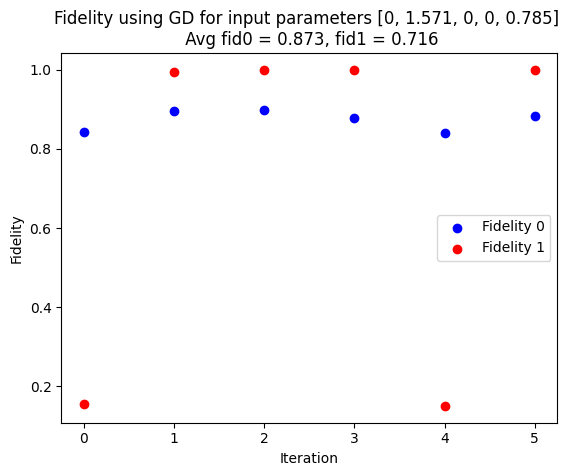

In [84]:
#plotting
import matplotlib.pyplot as plt
nit = 6
fid0, fid1 = [], []
# params0 = [0, m.pi/2, 0, 0, m.pi/4]
params0 = [0, m.pi/2, 0, 0, m.pi/4]
for i in range(nit):  # Adjust the range as needed
    fid = GD_search_lib(params= params0)[-1]
    fid0.append(fid[0])
    fid1.append(fid[1])

# Create a scatter plot
plt.scatter(range(len(fid0)), fid0, c='blue', label='Fidelity 0')
plt.scatter(range(len(fid1)), fid1, c='red', label='Fidelity 1')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.title(f"Fidelity using GD for input parameters {[round(i,3) for i in params0]} \n Avg fid0 = {round(sum(fid0)/len(fid0),3)}, fid1 = {round(sum(fid1)/len(fid1),3)}")
# plt.text(0.05, -0.05, f"Average fid0 = {round(sum(fid0)/len(fid0),3)}, Average fid1 = {}")
plt.legend()

# Show the plot
plt.show()


[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 13250, 13500, 13750, 14000, 14250, 14500, 14750, 15000, 15250, 15500, 15750, 16000, 16250, 16500, 16750, 17000, 17250, 17500, 17750, 18000, 18250, 18500, 18750, 19000, 19250, 19500, 19750, 20000, 20250, 20500, 20750, 21000, 21250, 21500, 21750, 22000, 22250, 22500, 22750, 23000, 23250, 23500, 23750, 24000, 24250, 24500, 24750, 25000, 25250, 25500, 25750, 26000, 26250, 26500, 26750, 27000, 27250, 27500, 27750, 28000, 28250, 28500, 28750, 29000, 29250, 29500, 29750, 30000, 30250, 30500, 30750, 31000, 31250, 31500, 31750, 32000, 32250, 32500, 32750, 33000, 33250, 33500, 33750, 34000, 34250, 34500, 34750, 35000, 35250, 35500, 35750, 36000, 36250, 36500, 36750, 37000, 37250

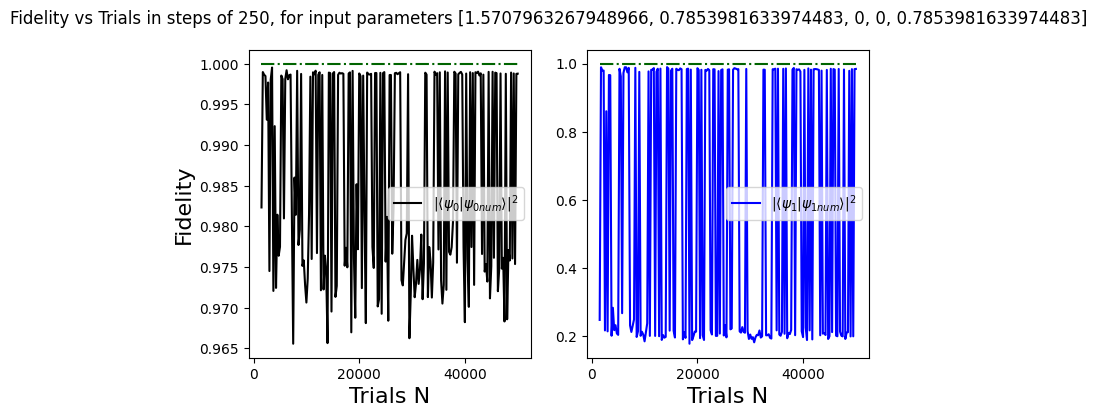

In [16]:
# creating a line plot : fid vs number of trials
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import math as m

def NPlotting_GD(N=10000, params=[0, m.pi/2, 0, 0, m.pi/4], step=1000, size=[8, 4], starting_step=5, show_title=False, colors=['black', 'blue'], font=16):
    count = N // step
    N_i = [step * i for i in range(1, count + 1)]
    fid0, fid1 = [], []
    print(N_i)
    for i in N_i:
        fid = GD_search_lib(N=i, params=params)[-1]
        fid0.append(fid[0])
        fid1.append(fid[1])

    fig, axs = plt.subplots(1, 2, figsize=size)

    axs[0].plot(N_i[starting_step:], fid0[starting_step:], color=colors[0], linestyle='-')
    axs[0].plot(N_i[starting_step:], [1.000 for _ in N_i[starting_step:]], color='darkgreen', linestyle='-.')
    axs[1].plot(N_i[starting_step:], fid1[starting_step:], color=colors[1])
    axs[1].plot(N_i[starting_step:], [1.000 for _ in N_i[starting_step:]], color='darkgreen', linestyle='-.')

    plt.subplots_adjust(wspace=0.2)

    axs[0].set_xlabel(r'Trials N', fontsize=font)
    axs[0].set_ylabel('Fidelity', fontsize=font)
    axs[1].set_xlabel(r'Trials N', fontsize=font)

    axs[0].legend([r'$|\langle \psi_0|\psi_{0num}\rangle|^2$'])
    axs[1].legend([r'$|\langle \psi_1|\psi_{1num}\rangle|^2$'])

    axs[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    axs[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

    if show_title:
        plt.suptitle(f'Fidelity vs Trials in steps of {step}, for input parameters {params}')

    plt.show()

NPlotting_GD(N=50000, params=[m.pi/2, m.pi/4, 0, 0, m.pi/4], step=250, show_title=True)

In [178]:
nj_vec = [907, 872, 1683, 812, 846, 1562, 856, 795, 1667]
lnL_list = [nj_vec[i]*sym.log(pr[i]) for i in range(len(pr))]        # likelihood list
lnL_abst = sum(lnL_list).evalf()                                  # likelihood fucntion
# lnL = lnL_abst.subs({theta1: 1.5984763884144184, theta2:.3281111984575599 , phi1:-0.4380749101756176, phi2:-1.1918940940201408, alpha:0.8184139830494875 })
lnL = lnL_abst.subs({theta1:.0991984575599 , theta2: 1.561763884144184, phi1:-0.580749101756176, phi2:-1.1918940940201408, alpha:0.8184139830494875 })

# [0.3281111984575599, 1.5984763884144184, -0.4380749101756176, -1.1918940940201408, 0.8184139830494875]
print(lnL)

-21321.3615986738


'# Likelihood fn\n\npr_analytical = [i.subs({theta1 : 0, theta2 : m.pi/2, phi1 : 0, phi2 : 0, alpha : m.pi/4}) for i in pr]\nprint("analytical:",pr_analytical)\n# print(sum(pr_analytical))\n\n#SEMI ANALYTICAL\nrho = Creating_states(Abstract=1)[-1]\npr_semanl_abs = [np.trace(np.dot(rho, POVM_elts[i])) for i in range(len(POVM_elts))]\npr_semanl = [i.subs({theta1 : 0, theta2 : m.pi/2, phi1 : 0, phi2 : 0, alpha : m.pi/4}) for i in pr_semanl_abs]\nprint("semi anlt",pr_semanl) \n\n\n# Numerical\nrho = Creating_states(Abstract=0)[-1]\npr_num = [np.trace(np.dot(rho, POVM_elts[i])) for i in range(len(POVM_elts))]\nprint("mun",pr_num) \n\n\n# numerical from the experimaent function\npr_exp = experiment(N = 100000, theta = [0,m.pi/2])[0]\nprint("exp",pr_exp) \n\n#corresponding n vector\nn = experiment(N = 100000, theta = [0,m.pi/2])[1]\nprint("n vector:",n) \n# verified, that all methods Converge to the same probabilities.'

In [78]:
# defining experimental n vector
n =[8305, 16778, 8453, 8330, 16841, 8234, 8283, 16600, 8176]    # for statres [0,m.pi/2]
n_normalized =[i/sum(n) for i in n]     # "experimental probabililtes"

#defining likelihood expression
lnL_list = [n[i]*sym.log(pr[i]) for i in range(len(pr))]
lnL = sum(lnL_list)         # created the likelihood fucntion
lnL_psuedo = sum([n[i]*m.log(n_normalized[i]) for i in range(len(n))])

# print("ideal answer",lnL.subs({phi1:0, phi2:0, theta1: 0, alpha: m.pi/4, theta2: m.pi/2})) # ideal answer -213681.506718260
# print("psuedo answer",lnL_psuedo)         # psuedo answer -213676.9481968622

#Defining likelihood as a funciton of parameters.


((logL([0,m.pi/4,m.pi/2,0,m.pi/4])))
# type(((logL([0,2,0,0,m.pi/4])).evalf()))


236662.525117525

In [ ]:
#rough
print(lnL_list[0])
print(lnL_list[0].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[1].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[2].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[3].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[4].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[5].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[6].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[7].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
print(lnL_list[8].subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2,  alpha: m.pi/4}))
k = [i.subs({phi1:0, phi2:0, theta1: 0, theta2: m.pi/2, alpha: m.pi/4}) for i in lnL_list]
print(k)
print('sum', sum(k))

8305*log(0.166666666666667*(-2.82842712474619*sin(theta1)*cos(phi1)*cos(theta1) + cos(theta1)**2 + 1)*sin(theta1)**2*cos(alpha)**2 + 0.166666666666667*(-2.82842712474619*sin(theta2)*cos(phi2)*cos(theta2) + cos(theta2)**2 + 1)*sin(alpha)**2*sin(theta2)**2)
-20637.1497264893
-30062.1403747083
-21004.9159106580
-20699.2723927340
-30175.0212212697
-20460.7213543544
-20582.4817801940
-29743.2071891857
-20316.5967686667
[-20637.1497264893, -30062.1403747083, -21004.9159106580, -20699.2723927340, -30175.0212212697, -20460.7213543544, -20582.4817801940, -29743.2071891857, -20316.5967686667]
sum -213681.506718260


In [187]:
#defining gradient function
def grad( params=[0,m.pi/2,0,0,m.pi/4] ,s=(1/500), show_calcs = False):    # point is the list of parameter : [theta1, theta2, phi1, phi2, alpha] respectively
    
    del_theta1 = logL(params = [params[0]+s,params[1],params[2],params[3],params[4]]) - logL(params = [params[0],params[1],params[2],params[3],params[4]])
    del_theta2 = logL(params = [params[0],params[1]+s,params[2],params[3],params[4]]) - logL(params = [params[0],params[1],params[2],params[3],params[4]])
    del_phi1   = logL(params = [params[0],params[1],params[2]+s,params[3],params[4]]) -   logL(params = [params[0],params[1],params[2],params[3],params[4]])
    del_phi2   = logL(params = [params[0],params[1],params[2],params[3]+s,params[4]]) -   logL(params = [params[0],params[1],params[2],params[3],params[4]])
    del_alpha  = logL(params = [params[0],params[1],params[2],params[3],params[4]+s]) -  logL(params = [params[0],params[1],params[2],params[3],params[4]])

    grad = [del_theta1/s,del_theta2/s,del_phi1/s,del_phi2/s,del_alpha/s]
    grad = [i if abs(i) > 1e-5 else 0 for i in grad]
    # for i in grad:
    #     if i > 1e9 or i is False:
    #         print(f"something wrong, gradient blowing up for parameter {i}")
    return grad
print(grad())


TypeError: logL() got an unexpected keyword argument 'params'

In [ ]:
# rough
s = 1/200

a = [-3.739e-01, 1.595e+00, 1.346e+00, -1.553e+00, 7.458e-01]
b = [0, m.pi/2, 0, 0, m.pi/4]
v0 = "original",logL(a)
v1 = "new",logL(b)

print("original",logL(a))
print("new",logL(b))

print("grad",grad([-0.4, .195, .346, -.553, 0.7458]))
b

original 205479.837211471
new 213681.506718260
grad [43961.3730165001, -42927.3838519148, -5530.56985090370, 1766.54624816729, 8904.13081909355]


[0, 1.5707963267948966, 0, 0, 0.7853981633974483]

In [185]:
#Grad descent
params_manual = [0,1,0,0,m.pi/4] # same 
def GD(param0 = [0,m.pi/2,0,0,m.pi/4], nit = 30, step = 1/200, show_calc = False):
    cost0 = logL(params0)
    s = step
    grad_new = grad(params = params0)
    params_new = params0
    values = []
    for i in range(nit):
        params_new = [params_new[i]-s*(grad_new[i]/8000) for i in range(len(params0))]
        grad_new = grad(params_new)
        value = [logL(params_new), params_new, grad_new, i]
        values.append(value)
        
        if i > (3/10)*nit//1 and i > 10:
            s = 5*step
            if i > (8/10)*nit//1:
                s = 15*step

        if show_calc == True:
            print(value,'\n ')
    return params_new

# GD(param0= params_manual, nit= 150, step = 1/200, show_calc = True)

In [ ]:
# [0, 1.5707963267948966, 0, 0, 0.7853981633974483]
#  [-0.0453554437925232, 1.56970457797804, 0.0969275280091279, -0.00179414849833847, 0.784096793392809]
#  [-0.372572520872864, 1.55890221385790, 1.23967731543922, 0.00149623378345495, 0.746416071840694]


42.742651516759416

In [61]:
# n =[8305, 16778, 8453, 8330, 16841, 8234, 8283, 16600, 8176]    # for statres [0,m.pi/2]
n = [1678, 0, 1639, 1656, 0, 1662, 1723, 0, 1642]
# n_normalized =[i/sum(n) for i in n]     # "experimental probabililtes"

#defining likelihood expression
lnL_list = [n[i]*sym.log(pr[i]) for i in range(len(pr))]
lnL = sum(lnL_list)         # created the likelihood fucntion
# lnL_psuedo = sum([n[i]*m.log(n_normalized[i]) for i in range(len(n))])


#Defining likelihood as a funciton of parameters.
def logL(p):
    k = lnL.subs({theta1: p[0], theta2: p[1], phi1: p[2], phi2: p[3], alpha: p[4]})
    return -k.evalf()

# ((logL([0,m.pi/4,m.pi/2,0,m.pi/4])))
# type(((logL([0,2,0,0,m.pi/4])).evalf()))

params0 = [0,1,0,0,m.pi/4]
bounds = [(-1,1), (-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180)]

opt = GDlib(logL, params0, bounds= bounds)
opt

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17917.4628513275
        x: [ 2.384e-03  1.568e+00  2.519e-08 -4.660e-01  1.571e+00]
      nit: 7
      jac: [ 0.000e+00  7.640e-02  0.000e+00  3.372e-01  1.033e-01]
     nfev: 54
     njev: 9
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [ ]:
s = Creating_states(params = opt.x)[0]
t = Creating_states()[0]

pprint(s)
pprint(t)
# sym.pprint(s)

fid1 = abs(sym.Matrix(s[0]).H*t[0])**2
fid2 = abs(sym.Matrix(s[1]).H*t[1])**2
fid = [fid1, fid2]
pprint(fid)

⎡⎡          0.930907673429997           ⎤  ⎡         -0.0239573001262181      
⎢⎢                                      ⎥  ⎢                                  
⎢⎢                    1.34611426055477⋅ⅈ⎥, ⎢                   -1.553343034274
⎣⎣-0.365254573618387⋅ℯ                  ⎦  ⎣0.999712982695865⋅ℯ               

    ⎤⎤
    ⎥⎥
95⋅ⅈ⎥⎥
    ⎦⎦
⎡⎡1⎤  ⎡ 0 ⎤⎤
⎢⎢ ⎥, ⎢   ⎥⎥
⎣⎣0⎦  ⎣1.0⎦⎦
[[0.86658909645085], [0.999426047770662]]


In [ ]:
def GDSearch(params0 = [0,1,0,0,m.pi/4], bounds = [(-1,1), (-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180),(-m.pi/2+m.pi/180,m.pi+m.pi/180)]):
    result = GDlib(logL, params0, bounds= bounds)
    params = result.x
    vecs = Creating_states(params = params, Abstract = 0)[0]
    if result.success is not True:
        print("\n CHECK \n- didnt succeed? \n ")
    phi1_num, phi2_num = sym.Matrix(vecs[0]), sym.Matrix(vecs[1])
    return([phi1_num, phi2_num], result)

GDSearch()[0]

[Matrix([
 [                         0.930907673429997],
 [-0.365254573618387*exp(1.34611426055477*I)]]),
 Matrix([
 [                       -0.0239573001262181],
 [0.999712982695865*exp(-1.55334303427495*I)]])]

In [89]:
a = []
for i in range(1000000):
    k= logL([0,m.pi/2,0,0,m.pi/4])
    a.append(k)
    if i%1000 == 0:
        print(i)

# ~100 operations per second 

0
1000
2000
3000
4000
5000


KeyboardInterrupt: 